### Предсказание звонков в колл-центр

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
def plot_importances(model):
    imps, names = model.feature_importances_, model.feature_name_
    imp_names = sorted(dict(zip(imps, names)).items(), key=lambda x: x[0])
    imps_, names_ = zip(*imp_names)
    plt.barh(names_[:20], imps_[:20])
    plt.show()
    
def validate_model(model, data_train, data_test):
    model_ = model
    
    # X and y
    X_train = data_train.loc[:, data_train.columns != 'is_callcenter']
    y_train = data_train.loc[:, 'is_callcenter']
    
    # validation
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
    model.fit(X_train_1, y_train_1)
    y_pred_1 = model.predict_proba(X_test_1)
    
    # plot
    plot_importances(model)
    
    print('validation:', roc_auc_score(y_test_1, y_pred_1[:, 1]))
    
    # test
    model_.fit(X_train, y_train)
    y_pred_test = model.predict_proba(data_test)
    
    return y_pred_test[:, 1]

### Функция для извлечения статистических характеристик

In [3]:
def stat_char(df_input, feature, cols_for_features):
    df = df_input.copy()
    df_ = df[cols_for_features].groupby(feature).agg('std')
    df_.columns = [el + feature + '_std' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)
    
    df_ = df[cols_for_features].groupby(feature).agg('mean')
    df_.columns = [el + feature + '_mean' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)    
    
    df_ = df[cols_for_features].groupby(feature).agg('median')
    df_.columns = [el + feature + '_median' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)
    
    df_ = df[cols_for_features].groupby(feature).agg('max')
    df_.columns = [el + feature + '_max' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)

    df_ = df[cols_for_features].groupby(feature).agg('min')
    df_.columns = [el + feature + '_min' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)

    df_ = df[cols_for_features].groupby(feature).quantile(0.25)
    df_.columns = [el + feature + '_q25' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)
    
    df_ = df[cols_for_features].groupby(feature).quantile(0.75)
    df_.columns = [el + feature + '_q75' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)
    
    df_ = df[cols_for_features].groupby(feature).nunique()
    df_.columns = [el + feature + '_count' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)

    df_ = df[cols_for_features].groupby(feature).agg('sum')
    df_.columns = [el + feature + '_sum' for el in list(df_.columns)]
    df_.reset_index(level=0, inplace=True)
    df = df.merge(df_, how='left', on = feature)
    
    return df

In [4]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
webstat = pd.read_csv('t1_webstat.csv')

In [5]:
# сохраним информацию о таргете
df_target = pd.DataFrame(list(zip(data_train['id'], data_train['is_callcenter'])), columns = ['id', 'is_callcenter'])

### Работаем с датой

In [6]:
data_train['create_time'] = pd.to_datetime(data_train['create_time'])
data_test['create_time'] = pd.to_datetime(data_test['create_time'])

data_train['day'] = data_train['create_time'].dt.day
data_train['month'] = data_train['create_time'].dt.month
data_train['year'] = data_train['create_time'].dt.year
data_train['hour'] = data_train['create_time'].dt.hour
data_train['dayofweek'] = data_train['create_time'].dt.dayofweek

data_test['day'] = data_test['create_time'].dt.day
data_test['month'] = data_test['create_time'].dt.month
data_test['year'] = data_test['create_time'].dt.year
data_test['hour'] = data_test['create_time'].dt.hour
data_test['dayofweek'] = data_test['create_time'].dt.dayofweek

# type to date
data_train['model_create_time'] = pd.to_datetime(data_train['model_create_time'])
data_test['model_create_time'] = pd.to_datetime(data_test['model_create_time'])

data_train['day_model'] = data_train['model_create_time'].dt.day
data_train['month_model'] = data_train['model_create_time'].dt.month
data_train['year_model'] = data_train['model_create_time'].dt.year
data_train['hour_model'] = data_train['model_create_time'].dt.hour
data_train['dayofweek_model'] = data_train['model_create_time'].dt.dayofweek

data_test['day_model'] = data_test['model_create_time'].dt.day
data_test['month_model'] = data_test['model_create_time'].dt.month
data_test['year_model'] = data_test['model_create_time'].dt.year
data_test['hour_model'] = data_test['model_create_time'].dt.hour
data_test['dayofweek_model'] = data_test['create_time'].dt.dayofweek

data_train = data_train.drop(['create_date'], axis=1)
data_test = data_test.drop(['create_date'], axis=1)

data_train.drop(['create_time'], inplace=True, axis=1)
data_test.drop(['create_time'], inplace=True, axis=1)

data_train.drop(['model_create_time'], inplace=True, axis=1)
data_test.drop(['model_create_time'], inplace=True, axis=1)

In [7]:
# cols for features

cols_for_features = list(data_test.columns)
cols_for_features = cols_for_features[:18] + cols_for_features[-10:]

### Cделаем статистические характеристики по сессии

In [8]:
webstat['date_time'] = pd.to_datetime(webstat['date_time'])
id_ind = list(data_train['sessionkey_id'].unique())
id_ind_1 = list(data_test['sessionkey_id'].unique())
id_ind = id_ind + id_ind_1
webstat = webstat[webstat['sessionkey_id'].isin(id_ind)]

In [9]:
web_time = webstat[['date_time', 'sessionkey_id']].groupby('sessionkey_id').apply(lambda x: x.max() - x.min())['date_time']
web_time = pd.DataFrame(web_time)

web_time.columns = [el + '_delta' for el in list(web_time.columns)]
web_time.reset_index(level=0, inplace=True)
webstat = webstat.merge(web_time, how='left', on = 'sessionkey_id')

In [10]:
webstat['date_time_delta'] = webstat['date_time_delta'].dt.seconds
webstat['day_w'] = webstat['date_time'].dt.day
webstat['month_w'] = webstat['date_time'].dt.month
webstat['year_w'] = webstat['date_time'].dt.year
webstat['hour_w'] = webstat['date_time'].dt.hour
webstat['dayofweek_w'] = webstat['date_time'].dt.dayofweek
webstat.drop(['date_time'], inplace=True, axis=1)
webstat_cols = list(webstat.columns)
webstat_cols.remove('date_time_delta')
webstat = stat_char(webstat, 'sessionkey_id', webstat_cols)

In [11]:
col_to_use_train = list(data_train.columns.difference(webstat.columns))
col_to_use_train.append('sessionkey_id')

data_train = data_train[col_to_use_train].merge(webstat, how='left', on = 'sessionkey_id')

In [12]:
data_train.drop('is_callcenter', axis=1, inplace=True)
data_train = data_train.merge(df_target, how='left', on = 'id')

In [13]:
col_to_use_test = list(data_test.columns.difference(webstat.columns))
col_to_use_test.append('sessionkey_id')

data_test = data_test[col_to_use_test].merge(webstat, how='left', on = 'sessionkey_id')

In [14]:
session_id_encoding = (
    webstat[webstat['page_type'] == 3]
    .groupby(['sessionkey_id'])
    .agg({'pageview_duration_sec': 'sum'})
    .rename(columns=({'pageview_duration_sec': 'sessionkey_id_encoding3'}))
)

In [15]:
data_train = data_train.groupby('id').mean()
data_train.drop('is_callcenter', axis=1, inplace=True)
data_train.reset_index(level=0, inplace=True)

data_train = data_train.merge(df_target, how='left', on='id')
data_train.drop('id', axis=1, inplace=True)

data_test = data_test.groupby('id').mean()

data_test.reset_index(level=0, inplace=True)
y_id = data_test.id
data_test.drop('id', axis=1, inplace=True)

In [17]:
data_train = (
    data_train
    .join(session_id_encoding, on=['sessionkey_id'], how='left')
    .fillna(-1)
)

data_test = (
    data_test
    .join(session_id_encoding, on=['sessionkey_id'], how='left')
    .fillna(-1)
)

In [18]:
data_train = data_train.drop(['sessionkey_id'], axis=1)
data_test = data_test.drop(['sessionkey_id'], axis=1)

In [19]:
# cols for features

cols_for_features = list(data_test.columns)
cols_for_features = cols_for_features[:28]

### Рассчитаем корень, логарифм, квадрат

In [20]:
for el in cols_for_features:
    data_train[el + '_sqr'] = data_train[el].apply(lambda x: x**2)
    data_train[el + '_lg'] = data_train[el].apply(lambda x: np.log(x))
    data_train[el + '_sqrt'] = data_train[el].apply(lambda x: np.sqrt(x))
    
    data_test[el + '_sqr'] = data_test[el].apply(lambda x: x**2)
    data_test[el + '_lg'] = data_test[el].apply(lambda x: np.log(x))
    data_test[el + '_sqrt'] = data_test[el].apply(lambda x: np.sqrt(x))

### LGBMClassifier

Настроим гиперпараметры модели (для ускорения привожу уже подобранные параметры)

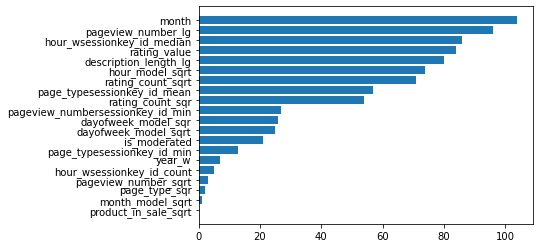

validation: 0.9355357802623259


In [23]:
model = LGBMClassifier(n_estimators=2000, metric = 'auc', objective='binary',
                        learning_rate=0.05, reg_alpha=1.5, n_jobs=-1)

y_pred = validate_model(model, data_train, data_test)

In [24]:
# dataframe of results

import pandas as pd

list_res = []
list_res.append(y_id)
list_res.append(y_pred)
df = pd.DataFrame(list_res)
df = df.transpose()
df.columns = ['id', 'is_callcenter']
df['id'] = df['id'].astype('int32')

df.to_csv('test_pred', index=False)

На лидерборде данное решение дало скор ROC AUC **0.92626**